## Feed forward neural network

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn import preprocessing

We use the breast cancer dataset for binary classification. We are going to normalise and scale the data because certain activation functions (e.g. relu) behave poorly on unscaled data and also to achieve faster and better convergence.


In [2]:
bc_data = datasets.load_breast_cancer()

X = bc_data.data
y = bc_data.target.astype("float")
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.33,
                                                    random_state=42)
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

We will implement our feed forward neural net to support an arbitrary number of layers and two activation functions for the hidden layers (relu and sigmoid). For the output layer we will have a single sigmoid unit and use the binary crossentropy loss for binary classification.

We will need to implement the forward pass to make predictions and the backward pass that computes the error derivatives with respect to the weights of each layer using the backpropagation algorithm and the chain rule for derivatives.

In [3]:
class MLPModel:
    def __init__(self):
        self.n_layers = None
        self.weights = None
        self.input_dim = None
        self.n_hidden = None
        self.is_built = False

    @staticmethod
    def relu(x):
        return np.maximum(x, 0)

    @staticmethod
    def sigmoid(x):
        return 1. / (1 + np.exp(-x))

    def sigmoid_backward(self, da, z):
        sig = self.sigmoid(z)
        return da * sig * (1 - sig)

    @staticmethod
    def relu_backward(da, z):
        dz = np.array(da, copy=True)
        dz[z <= 0] = 0
        return dz

    def build_model(self, input_dim, n_hidden, n_layers=2, activation="relu"):
        self.n_layers = n_layers
        self.input_dim = input_dim
        self.weights = []
        self.activations = []
        prev_d = input_dim
        for l, d in enumerate(n_hidden):
            w = np.random.normal(0, np.sqrt(2/prev_d), (d, prev_d))    # N(0, sqrt(2/inp_dim))
            b = np.random.normal(0, np.sqrt(2/prev_d), (d, 1))

            prev_d = d
            self.weights.append((w, b))
            if activation == "relu":
                self.activations.append(self.relu)
            elif activation == "sigmoid":
                self.activations.append(self.sigmoid)
            else:
                raise("Unsupported activation")

        # Sigmoid output layer
        w = np.random.normal(0, np.sqrt(2/prev_d), (1, prev_d))    # N(0, sqrt(2/inp_dim))
        b = np.random.normal(0, np.sqrt(2/prev_d), (1, 1))
        self.weights.append((w, b))
        self.activations.append(self.sigmoid)

        self.is_built = True

    def forward(self, x):
        h_i = x.T
        # the initial input is the first in mem
        z = [h_i]
        h = [h_i]
        for i, ((w, b), activation_fn) in enumerate(zip(self.weights, self.activations)):
            z_i = np.dot(w, h_i) + b
            z.append(z_i)
            h_i = activation_fn(z_i)
            h.append(h_i)

        return np.squeeze(h_i), (z, h)

    def backward(self, h, y, mem):
        da = - (np.divide(y, h) - np.divide(1 - y, 1 - h))
        grads = []
        for i in range(self.n_layers, -1, -1):
            w, b = self.weights[i]
            activation_fn = self.activations[i]
            # mem also has the first layer so it is i + 1
            z_cur, h_cur = mem[0][i+1], mem[1][i+1]
            z_prev, h_prev = mem[0][i], mem[1][i]
            m = h_prev.shape[1]

            if activation_fn.__name__ == "relu":
                dz = self.relu_backward(da, z_cur)
            elif activation_fn.__name__ == "sigmoid":
                dz = self.sigmoid_backward(da, z_cur)
            else:
                raise("Unsupported activation")
            
            dw = np.dot(dz, h_prev.T) / m
            db = np.sum(dz, axis=1, keepdims=True) / m
            da = np.dot(w.T, dz)

            grads.append((dw, db))
        
        return grads

    def update_weights(self, grads, lr):
        grads = list(reversed(grads))    # grads have the opposite order
        for i, (w, b) in enumerate(self.weights):
            grad_w, grad_b = grads[i]
            w -= lr*grad_w
            b -= lr*grad_b
            self.weights[i] = (w, b)

    def crossentropy_loss(self, h, y, eps=1e-8):
        m = h.shape[0]
        # without eps log(0) will eval to nan
        j = -(1.0 / m) * (np.dot(y, np.log(h + eps).T) + np.dot(1.0 - y, np.log(1.0 - h + eps).T))
        return np.squeeze(j)


We will train our neural net with mini batch gradient decent. We will have a simple generator to feed batches of data for training and prediction. The training will stop when we either reach the total iterations or the training loss falls bellow a threshold.

When making predictions we are going to use 0.5 as our threshold for separating classes.

In [4]:
class MLPClassifier:
    def __init__(self, n_hidden, n_layers=2, lr=0.003, activation="relu"):
        assert len(n_hidden) == n_layers
        self.n_hidden = n_hidden
        self.n_layers = n_layers
        self.lr = lr
        self.activation = activation
        self.model = MLPModel()

    def make_datagen(self, X, y=None, batch_size=16):
        for i in range(0, len(X), batch_size):
            x_batch = X[i:i+batch_size]
            if y is not None:    # for training
                y_batch = y[i:i+batch_size]
                assert x_batch.shape[0] == y_batch.shape[0]
                yield x_batch, y_batch
            else:    # for prediction
                yield x_batch

    def shuffle_data(self, X, y):
        x_temp = np.concatenate([X, np.expand_dims(y, axis=1)], axis=1)
        np.random.shuffle(x_temp)
        X, y = x_temp[:, :-1], np.squeeze(x_temp[:, -1])
        return X, y

    def fit(self, X_train, y_train, epochs=100, batch_size=16, tol=0.0001, shuffle=True):
        self.model.build_model(
                input_dim=X_train.shape[1],
                n_layers=self.n_layers,
                n_hidden=self.n_hidden,
                activation=self.activation)
        
        epoch = 0
        losses = []
        avg_loss = float("inf")
        while epoch < epochs and avg_loss > tol:
            datagen = self.make_datagen(X_train, y_train, batch_size)
            epoch_loss = 0
            for i, (x, y) in enumerate(datagen):
                h, mem = self.model.forward(x)
                loss = self.model.crossentropy_loss(h, y)
                epoch_loss += loss

                grads = self.model.backward(h, y, mem)

                self.model.update_weights(grads, self.lr)

            avg_loss = epoch_loss / (i+1)
            losses.append(avg_loss)

            if shuffle:
                X_train, y_train = self.shuffle_data(X_train, y_train)
            
            epoch += 1
        
        return losses

    def predict(self, X_test, batch_size=16):
        assert self.model.is_built    # will fail if fit hasn't been called
        datagen = self.make_datagen(X_test, batch_size=batch_size)
        y_ret = []
        for i, x in enumerate(datagen):
            y_pred, _ = self.model.forward(x)
            # threshold at 0.5
            y_pred[y_pred >= 0.5] = 1
            y_pred[y_pred < 0.5] = 0
            y_ret.append(y_pred)

        return np.concatenate(y_ret, axis=0)

We will first build a model with two hidden layers (with 50 and 20 units respectively) and relu activations. Then we train our model for 100 epochs and plot the training loss curves. 

We can then make predictions and compute the f1 score over the test set. 

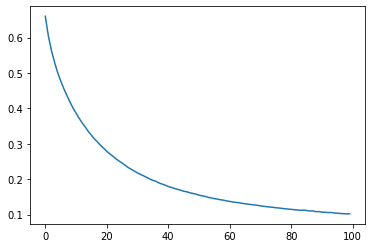

In [5]:
mlp_clf = MLPClassifier(n_hidden=[50, 20], lr=0.003, activation="relu")
losses = mlp_clf.fit(X_train, y_train, epochs=100, batch_size=32)
plt.plot(range(len(losses)), losses)

In [6]:
y_r = mlp_clf.predict(X_test)

In [7]:
f1_score(y_test, y_r, average="micro")

0.9680851063829787

We can also try a model with the same architecture and sigmoid activations. This model requires a lot more training epochs to converge. Also, we can see that the f1 score over the test set is lower than the previous model. 

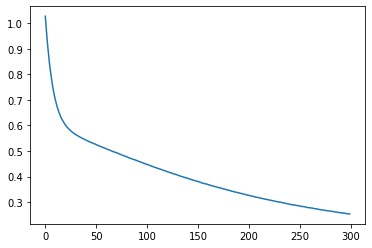

In [14]:
mlp_clf = MLPClassifier(n_hidden=[50, 20], lr=0.003, activation="sigmoid")
losses = mlp_clf.fit(X_train, y_train, epochs=300, batch_size=32)
plt.plot(range(len(losses)), losses)

In [15]:
y_r = mlp_clf.predict(X_test)

In [16]:
f1_score(y_test, y_r, average="micro")

0.9361702127659575